# Fruit Ninja with Mediapipe
使用方法請至最下方

## 0. env set up 套件與環境安裝
#### pip install cvzone https://github.com/cvzone/cvzone
#### pip install mediapipe
#### 1. import cvzone - for hand dectector(also install mediapipe) 手部偵測
#### 2. import socket - for sending message to unity 通訊

## 1.python - capture hands 偵測手部

In [ ]:
from cvzone.HandTrackingModule import HandDetector
import cv2
import socket
 
cap = cv2.VideoCapture(0)
cap.set(3, 1280)
#cap.set(4, 720)


success, img = cap.read()
#read the height & width
h, w, _ = img.shape

#hand dectecter
detector = HandDetector(detectionCon=0.8, maxHands=1)
 
#using for sending position to unity(by socket)    
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverAddressPort = ("127.0.0.1", 5052) #make sure the port is not used
 
#webcam capture hand loop    
while True:
    # Get image frame
    success, img = cap.read()
    # Find the hand and its landmarks
    hands, img = detector.findHands(img)  # with draw
    # hands = detector.findHands(img, draw=False)  # without draw
    
    data = [] #reset data (because we need the data be different in every frame)
 
    if hands:
        # Hand 1
        hand = hands[0]
        lmList = hand["lmList"]  # List of 21 Landmark points
        for lm in lmList:
            data.extend([lm[0], h - lm[1], lm[2]]) #reverse y
 
        sock.sendto(str.encode(str(data)), serverAddressPort) #work with unity - sending data
 
    # Display
    cv2.imshow("Image", img)
    cv2.waitKey(1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### LandMarks對照號碼

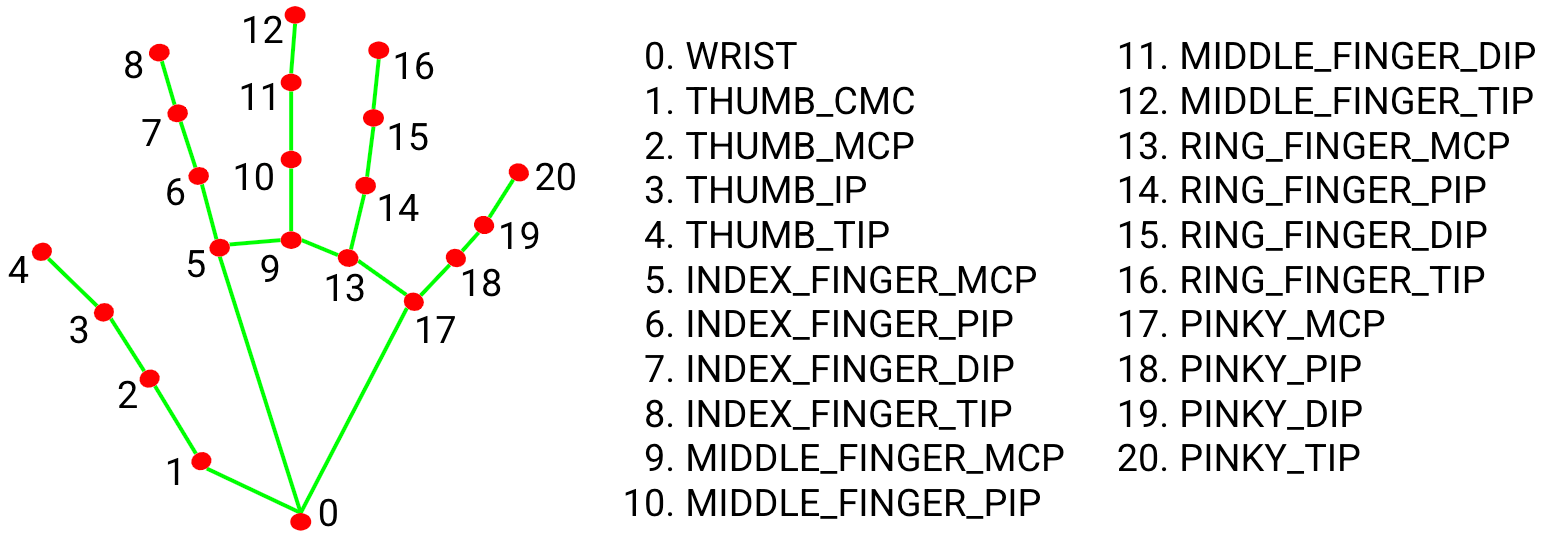


## 2. Go to unity --Receive data[ ] from python by protocol 
## 在unity存取data的資料

### use UDP recieve script

In [ ]:
using UnityEngine;
using System;
using System.Text;
using System.Net;
using System.Net.Sockets;
using System.Threading;

public class UDPReceive : MonoBehaviour
{

    Thread receiveThread;
    UdpClient client; 
    public int port = 5052;
    public bool startRecieving = true;
    public bool printToConsole = false;
    public string data;


    public void Start()
    {

        receiveThread = new Thread(
            new ThreadStart(ReceiveData));
        receiveThread.IsBackground = true;
        receiveThread.Start();
    }


    // receive thread
    private void ReceiveData()
    {

        client = new UdpClient(port);
        while (startRecieving)
        {

            try
            {
                IPEndPoint anyIP = new IPEndPoint(IPAddress.Any, 0);
                byte[] dataByte = client.Receive(ref anyIP);
                data = Encoding.UTF8.GetString(dataByte);

                if (printToConsole) { print(data); }
            }
            catch (Exception err)
            {
                print(err.ToString());
            }
        }
    }

}

## 3. Set up the hand & points 將資料點對應到需要的物件

In [ ]:
using System.Collections;
using System.Collections.Generic;
using UnityEngine;

public class HandTracking : MonoBehaviour
{
    // Start is called before the first frame update
    public UDPReceive udpReceive;
    public GameObject[] handPoints;
    void Start()
    {

    }

    // Update is called once per frame
    void Update()
    {
        string data = udpReceive.data;

        //remove the []
        data = data.Remove(0, 1);
        data = data.Remove(data.Length - 1, 1);

        print(data);

        //setting the value into string array
        string[] points = data.Split(',');
        print(points[0]);

        //0        1*3      2*3
        //x1,y1,z1,x2,y2,z2,x3,y3,z3

        //convert to float
        for (int i = 0; i < 21; i++)
        {

            float x = 7 - float.Parse(points[i * 3]) / 100;
            float y = float.Parse(points[i * 3 + 1]) / 100;
            float z = float.Parse(points[i * 3 + 2]) / 100;

            handPoints[i].transform.localPosition = new Vector3(x, y, 0);

        }


    }
}

Lines between points

In [ ]:
using System.Collections;
using System.Collections.Generic;
using UnityEngine;

public class LineCode : MonoBehaviour
{

    LineRenderer lineRenderer;

    public Transform origin;
    public Transform destination;

    // Start is called before the first frame update
    void Start()
    {
        lineRenderer = GetComponent<LineRenderer>();
        lineRenderer.startWidth = 0.1f;
        lineRenderer.endWidth = 0.1f;
    }

    // Update is called once per frame
    void Update()
    {
        lineRenderer.SetPosition(0, origin.position);
        lineRenderer.SetPosition(1, destination.position);
    }
}

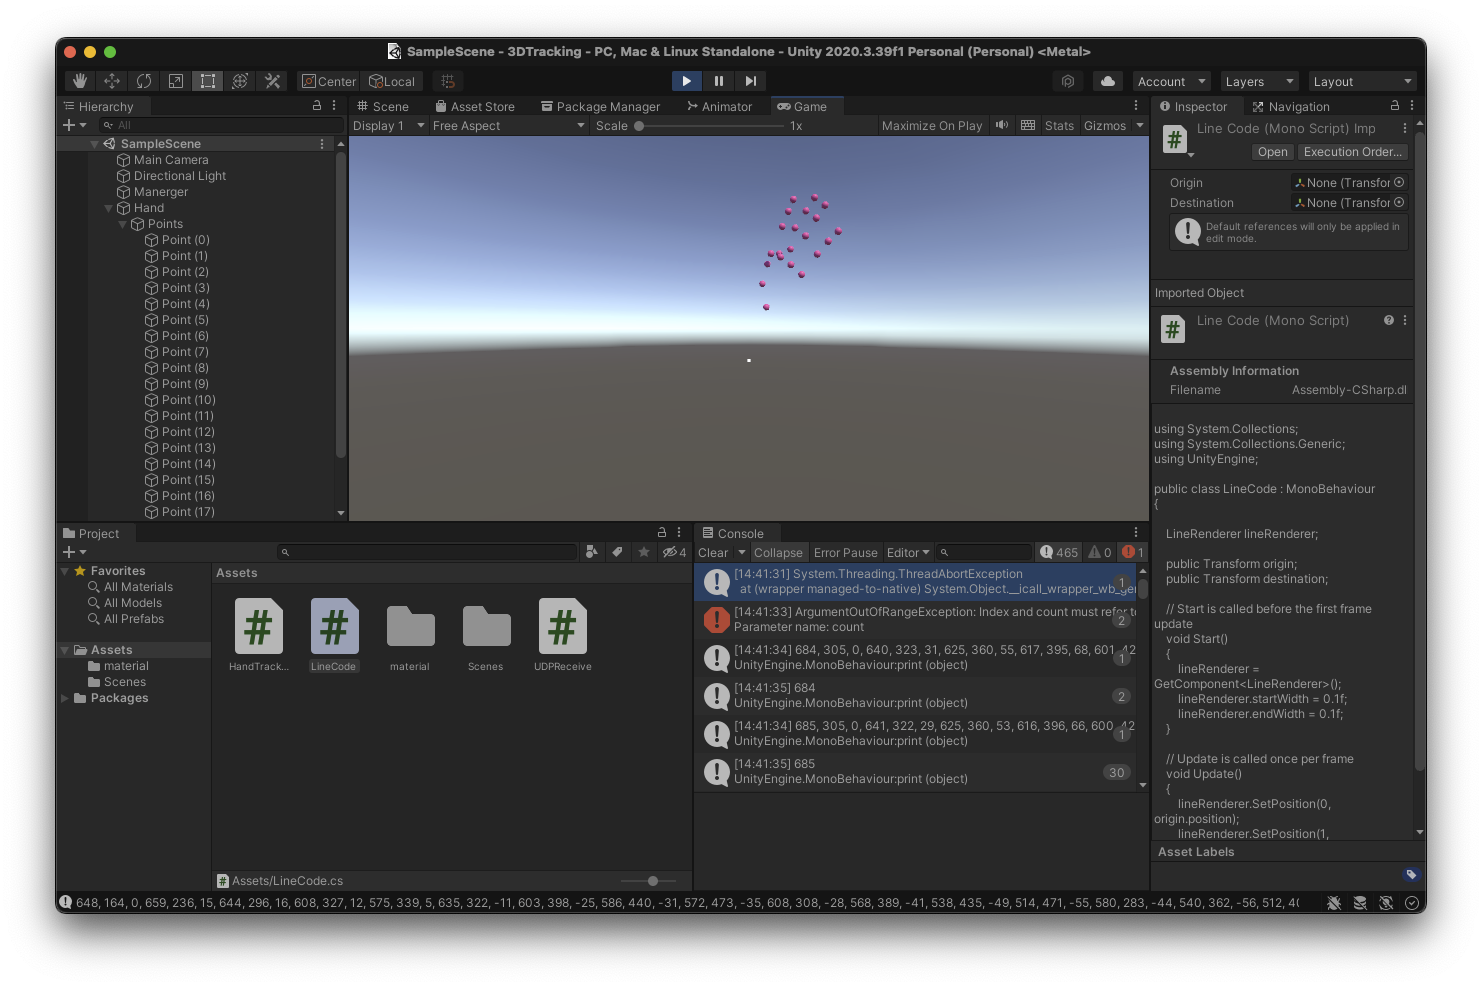

## 4. Set up Unity game scene 設定遊戲場景

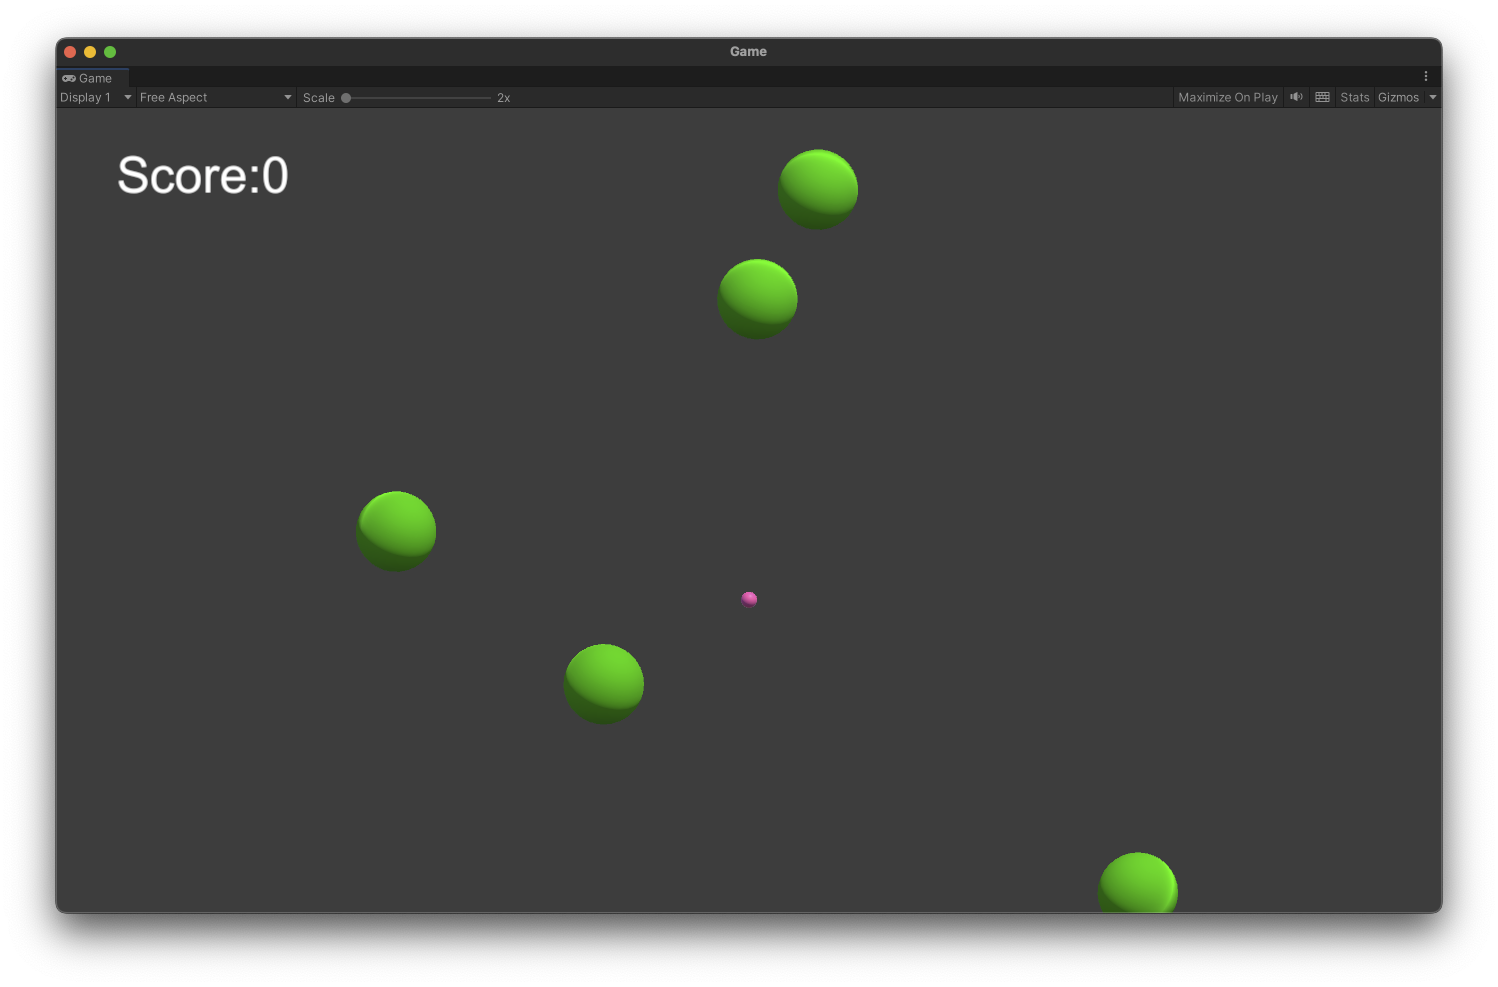

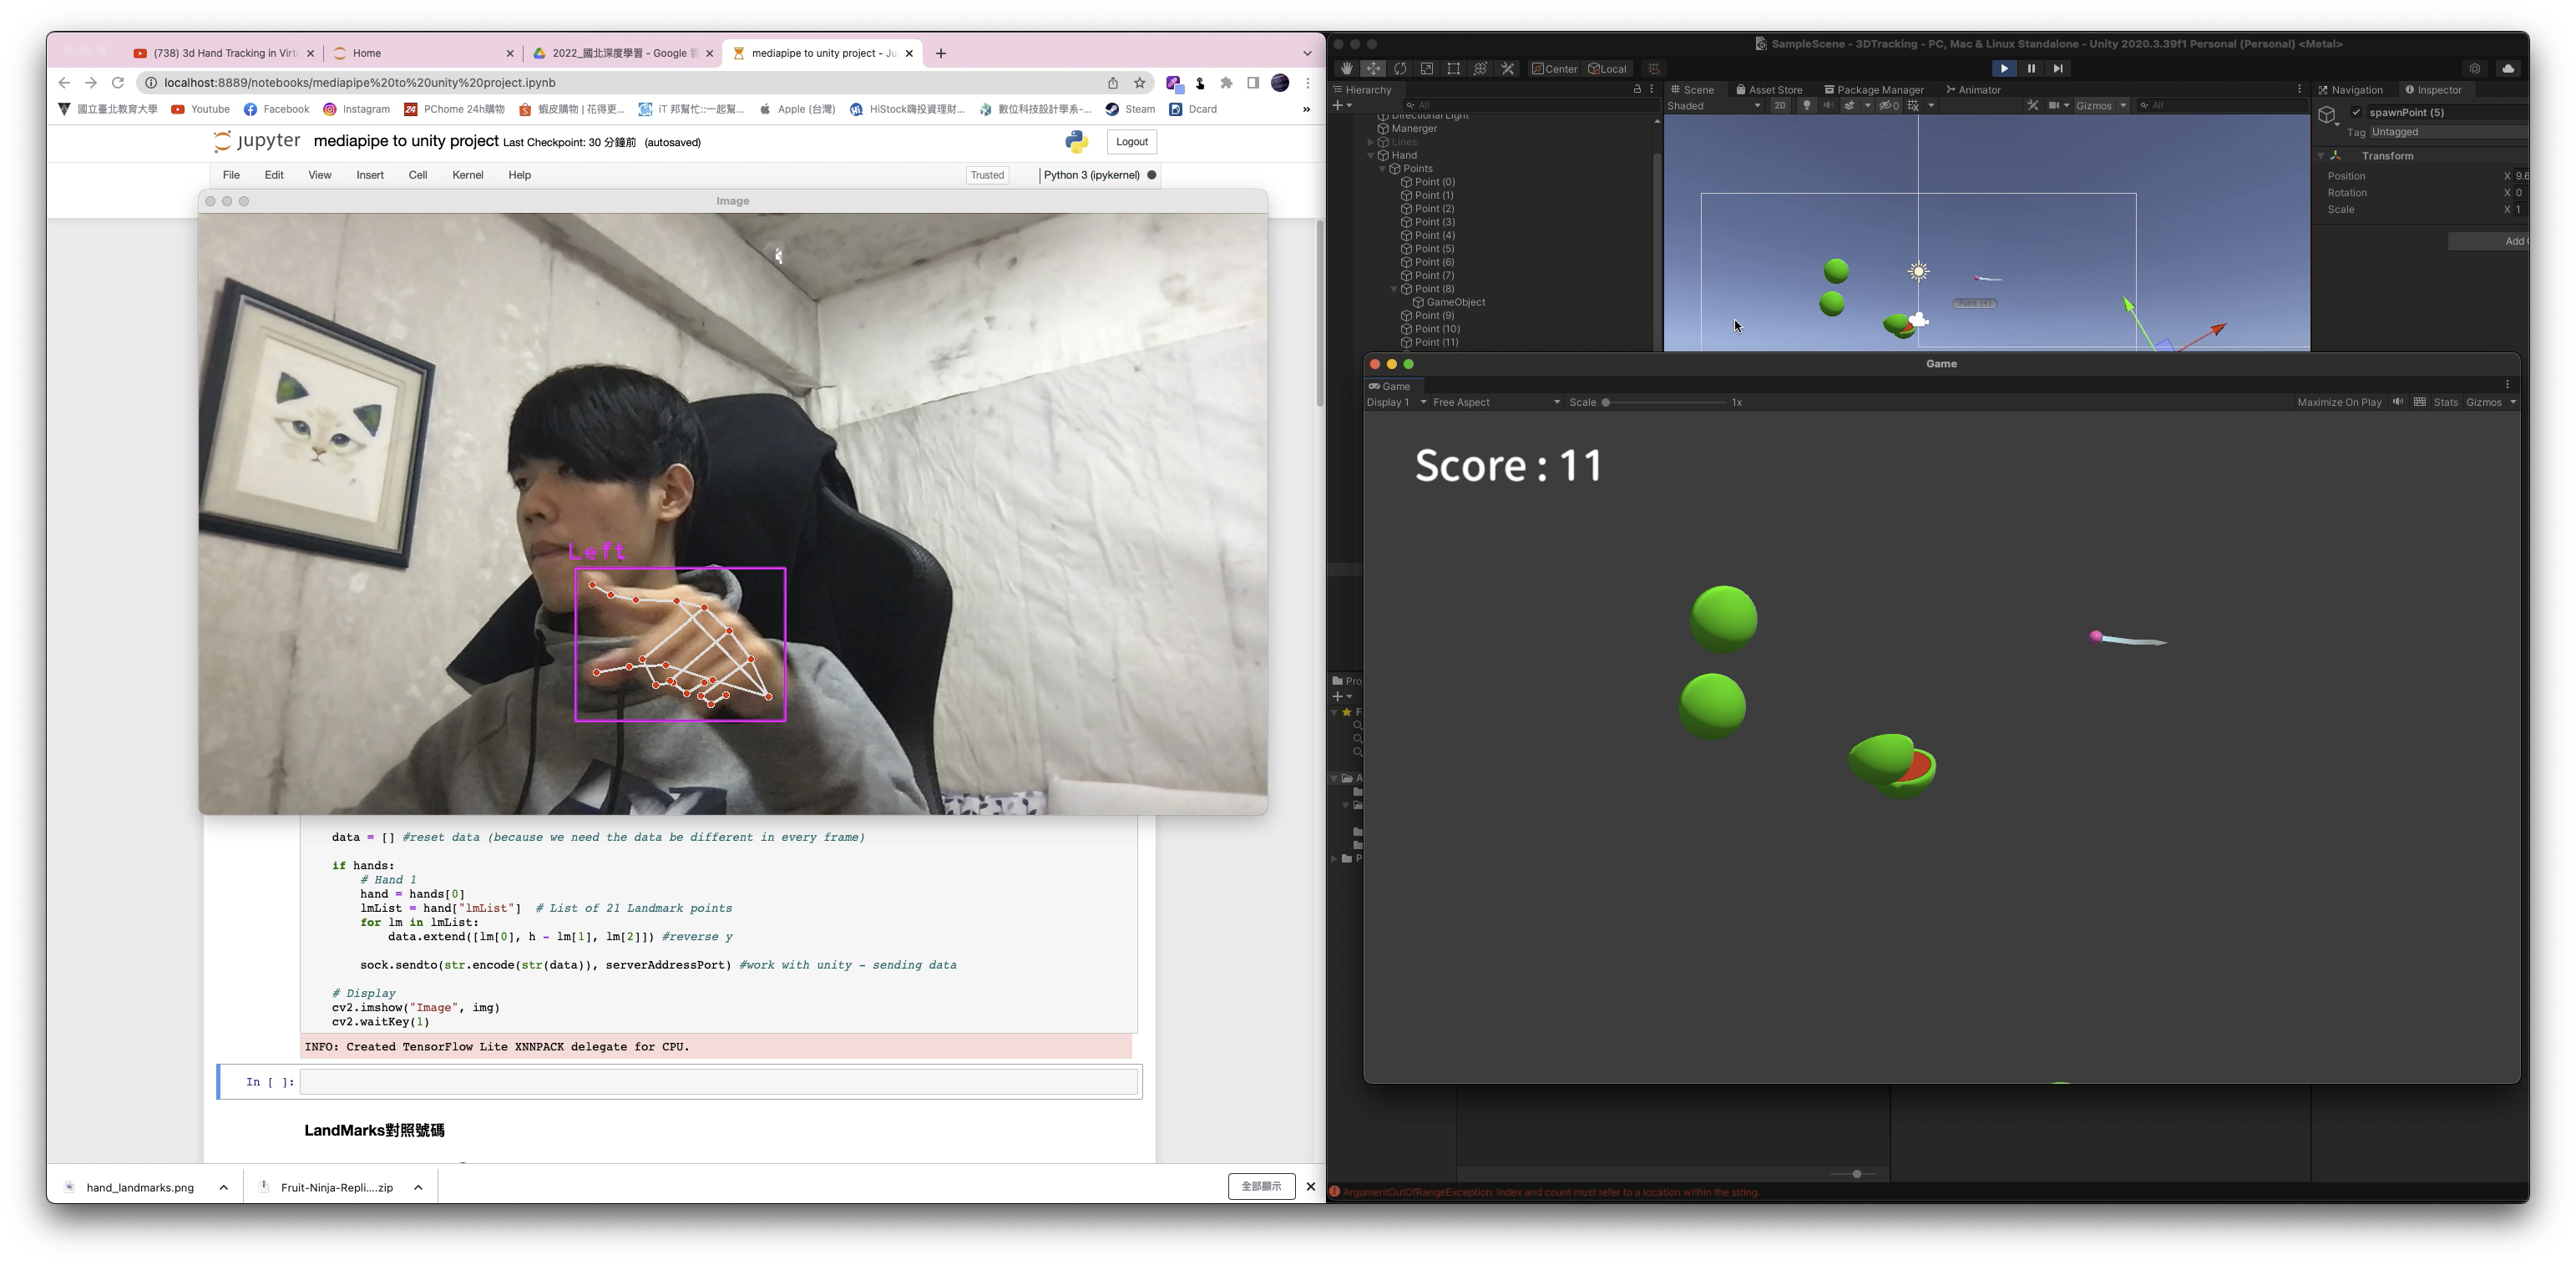

ref:
https://www.youtube.com/watch?v=RQ-2JWzNc6k
https://github.com/cvzone/cvzone

### usage
#### 用步驟一執行後、unity設定完接收「點」後，開啟unity執行 
#### run step 1. , then set up your unity game and recieve data script, last run unity game